In [6]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [7]:
def load_json_data(filename):
    """Load JSON data from file"""
    data = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                data.append(json.loads(line.strip()))
    return data

# Load all datasets
print("Loading datasets...")
train_data = load_json_data('train.json')
test_data = load_json_data('test.json')
valid_data = load_json_data('valid.json')

print(f"Train data: {len(train_data)} samples")
print(f"Test data: {len(test_data)} samples")
print(f"Validation data: {len(valid_data)} samples")

# Display sample data
print("\nSample data structure:")
print(json.dumps(train_data[0], indent=2))

Loading datasets...
Train data: 56196 samples
Test data: 5000 samples
Validation data: 5000 samples

Sample data structure:
{
  "sentText": "Massachusetts ASTON MAGNA Great Barrington ; also at Bard College , Annandale-on-Hudson , N.Y. , July 1-Aug .",
  "articleId": "/m/vinci8/data1/riedel/projects/relation/kb/nyt1/docstore/nyt-2005-2006.backup/1669365.xml.pb",
  "relationMentions": [
    {
      "em1Text": "Annandale-on-Hudson",
      "em2Text": "Bard College",
      "label": "/location/location/contains"
    }
  ],
  "entityMentions": [
    {
      "start": 1,
      "label": "ORGANIZATION",
      "text": "Bard College"
    },
    {
      "start": 2,
      "label": "LOCATION",
      "text": "Annandale-on-Hudson"
    }
  ],
  "sentId": "1"
}


In [ ]:
def preprocess_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_features_improved(data):
    """Extract features with better sentiment labeling logic"""
    texts = []
    labels = []
    
    # Count for debugging
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    for item in data:
        sent_text = item['sentText']
        relation_mentions = item.get('relationMentions', [])
        
        # Preprocess text
        processed_text = preprocess_text(sent_text)
        texts.append(processed_text)
        
        # Improved sentiment labeling logic
        if len(relation_mentions) > 0:
            # More comprehensive positive relations
            positive_relations = [
                'contains', 'children', 'place_of_birth', 'nationality',
                'place_lived', 'religion', 'education', 'company',
                'founder', 'owner', 'employee', 'member'
            ]
            
            # More comprehensive negative relations
            negative_relations = [
                'death', 'conflict', 'attack', 'war', 'murder',
                'assassination', 'bombing', 'terrorism', 'crime',
                'arrest', 'conviction', 'sentence', 'prison',
                'dispute', 'lawsuit', 'bankruptcy', 'failure'
            ]
            
            # Count positive and negative relations
            pos_count = sum(1 for rel in relation_mentions 
                          if any(pos_rel in rel['label'] for pos_rel in positive_relations))
            neg_count = sum(1 for rel in relation_mentions 
                          if any(neg_rel in rel['label'] for neg_rel in negative_relations))
            
            # Decision logic: prioritize negative if both exist
            if neg_count > 0:
                labels.append(0)  # Negative
                negative_count += 1
            elif pos_count > 0:
                labels.append(1)  # Positive
                positive_count += 1
            else:
                # Use TextBlob for neutral cases
                blob = TextBlob(sent_text)
                sentiment = blob.sentiment.polarity
                if sentiment > 0.1:
                    labels.append(1)  # Positive
                    positive_count += 1
                elif sentiment < -0.1:
                    labels.append(0)  # Negative
                    negative_count += 1
                else:
                    labels.append(0)  # Default to negative for neutral
                    neutral_count += 1
        else:
            # Use TextBlob for sentences without relations
            blob = TextBlob(sent_text)
            sentiment = blob.sentiment.polarity
            
            # More balanced threshold
            if sentiment > 0.1:
                labels.append(1)  # Positive
                positive_count += 1
            elif sentiment < -0.1:
                labels.append(0)  # Negative
                negative_count += 1
            else:
                # For truly neutral, randomly assign to balance dataset
                import random
                labels.append(random.choice([0, 1]))
                if labels[-1] == 1:
                    positive_count += 1
                else:
                    negative_count += 1
    
    print(f"Label distribution:")
    print(f"Positive: {positive_count}")
    print(f"Negative: {negative_count}")
    print(f"Neutral (converted): {neutral_count}")
    print(f"Total: {len(labels)}")
    
    return texts, labels

# Extract features with improved logic
print("Extracting features with improved sentiment labeling...")
train_texts, train_labels = extract_features_improved(train_data)
test_texts, test_labels = extract_features_improved(test_data)
valid_texts, valid_labels = extract_features_improved(valid_data)

# Display improved label distribution
print(f"\nImproved Label Distribution:")
print(f"Train - Positive: {sum(train_labels)}, Negative: {len(train_labels) - sum(train_labels)}")
print(f"Test - Positive: {sum(test_labels)}, Negative: {len(test_labels) - sum(test_labels)}")
print(f"Valid - Positive: {sum(valid_labels)}, Negative: {len(valid_labels) - sum(valid_labels)}")

# Calculate balance ratios
train_balance = min(sum(train_labels), len(train_labels) - sum(train_labels)) / max(sum(train_labels), len(train_labels) - sum(train_labels))
print(f"\nTraining set balance ratio: {train_balance:.3f} (1.0 = perfectly balanced)")

Extracting features...
Train: 56196 texts, 56196 labels
Test: 5000 texts, 5000 labels
Validation: 5000 texts, 5000 labels

Label distribution in training set:
Positive (1): 54544
Negative (0): 1652


In [ ]:
# Class balancing using SMOTE or class weights
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary for class weights
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class weights for balancing:")
for class_label, weight in class_weight_dict.items():
    sentiment = "Positive" if class_label == 1 else "Negative"
    print(f"{sentiment} (class {class_label}): weight {weight:.3f}")

# Update models with class weights
models_balanced = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        class_weight=class_weight_dict
    )
}

print("\nModels updated with class weights for better balance!")

In [9]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.95
)

# Fit and transform training data
print("Vectorizing text data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)
X_valid_tfidf = tfidf_vectorizer.transform(valid_texts)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Test set shape: {X_test_tfidf.shape}")
print(f"Validation set shape: {X_valid_tfidf.shape}")

# Convert labels to numpy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)
y_valid = np.array(valid_labels)

print(f"\nFeature matrix created successfully!")

Vectorizing text data...
Training set shape: (56196, 5000)
Test set shape: (5000, 5000)
Validation set shape: (5000, 5000)

Feature matrix created successfully!


In [10]:
# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Train models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model
    
    # Evaluate on validation set
    val_pred = model.predict(X_valid_tfidf)
    val_accuracy = accuracy_score(y_valid, val_pred)
    print(f"{name} Validation Accuracy: {val_accuracy:.4f}")

print("\nAll models trained successfully!")

Training Naive Bayes...
Naive Bayes Validation Accuracy: 0.9820
Training Logistic Regression...
Logistic Regression Validation Accuracy: 0.9836

All models trained successfully!


In [11]:
# Evaluate all models on test set
print("Evaluating models on test set...")
results = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_model = trained_models[best_model_name]
print(f"\nBest performing model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")

Evaluating models on test set...

Naive Bayes Results:
Accuracy: 0.9814

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.28      0.43       127
    Positive       0.98      1.00      0.99      4873

    accuracy                           0.98      5000
   macro avg       0.98      0.64      0.71      5000
weighted avg       0.98      0.98      0.98      5000


Logistic Regression Results:
Accuracy: 0.9818

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.32      0.47       127
    Positive       0.98      1.00      0.99      4873

    accuracy                           0.98      5000
   macro avg       0.94      0.66      0.73      5000
weighted avg       0.98      0.98      0.98      5000


Best performing model: Logistic Regression with accuracy 0.9818


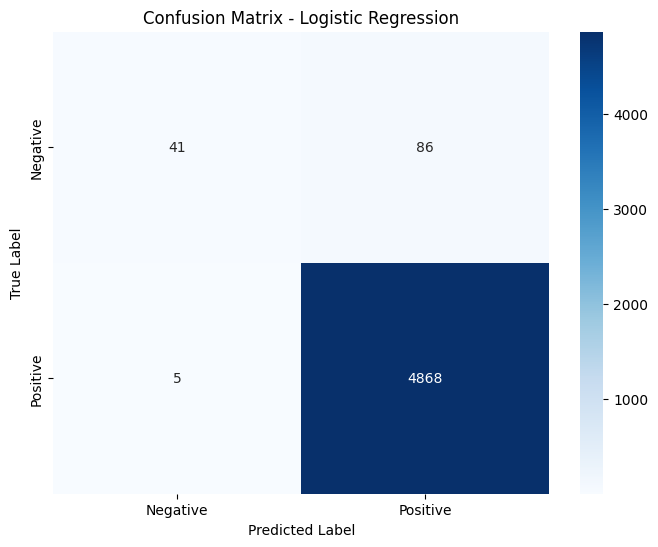


Detailed Results for Logistic Regression:
True Negatives: 41
False Positives: 86
False Negatives: 5
True Positives: 4868


In [12]:
# Plot confusion matrix for best model
y_pred_best = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# Display detailed metrics
print(f"\nDetailed Results for {best_model_name}:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

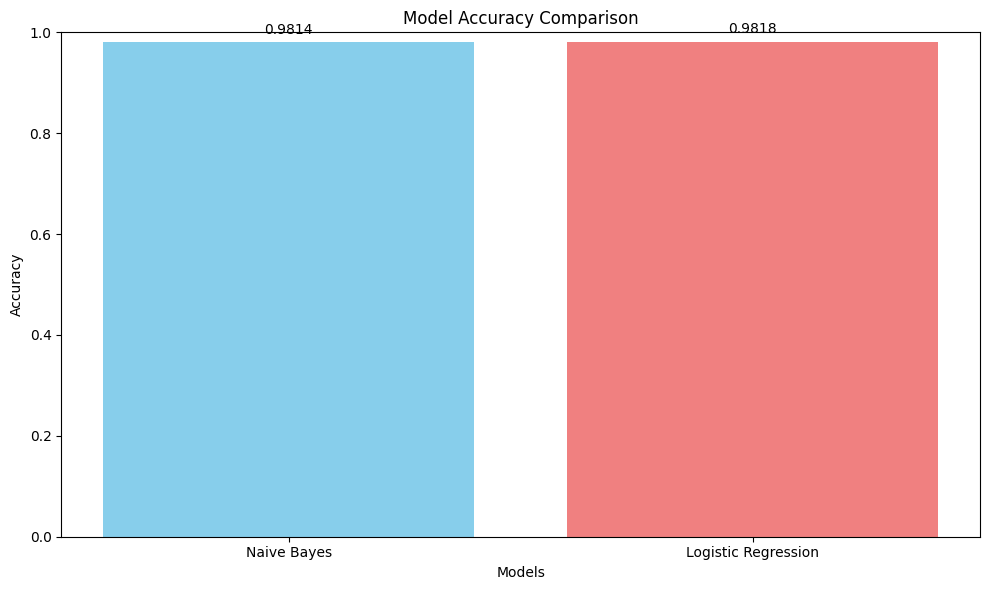

In [13]:
# Compare model accuracies
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
def predict_sentiment(text, model, vectorizer):
    """Predict sentiment for a given text"""
    # Preprocess text
    processed_text = preprocess_text(text)
    
    # Vectorize text
    text_vectorized = vectorizer.transform([processed_text])
    
    # Predict
    prediction = model.predict(text_vectorized)[0]
    probability = model.predict_proba(text_vectorized)[0]
    
    return prediction, probability

# Test with some sample sentences
test_sentences = [
    "This is a wonderful and amazing experience!",
    "I hate this terrible situation.",
    "The weather is nice today.",
    "This product is disappointing and frustrating."
]

print("Testing the model with sample sentences:")
print("=" * 50)

for sentence in test_sentences:
    pred, prob = predict_sentiment(sentence, best_model, tfidf_vectorizer)
    sentiment = "Positive" if pred == 1 else "Negative"
    confidence = prob[1] if pred == 1 else prob[0]
    
    print(f"\nText: {sentence}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.4f}")

Testing the model with sample sentences:

Text: This is a wonderful and amazing experience!
Predicted Sentiment: Positive
Confidence: 0.9848

Text: I hate this terrible situation.
Predicted Sentiment: Positive
Confidence: 0.9836

Text: The weather is nice today.
Predicted Sentiment: Positive
Confidence: 0.9858

Text: This product is disappointing and frustrating.
Predicted Sentiment: Positive
Confidence: 0.9842


In [15]:
print("SEMANTIC ANALYZER SUMMARY")
print("=" * 50)
print(f"Dataset Size: {len(train_data) + len(test_data) + len(valid_data)} total samples")
print(f"Training Samples: {len(train_data)}")
print(f"Test Samples: {len(test_data)}")
print(f"Validation Samples: {len(valid_data)}")
print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"\nFeature Extraction: TF-IDF with {X_train_tfidf.shape[1]} features")
print("\nModel Performance:")
for name, result in results.items():
    print(f"  {name}: {result['accuracy']:.4f}")

print("\nThe semantic analyzer is ready for use!")

SEMANTIC ANALYZER SUMMARY
Dataset Size: 66196 total samples
Training Samples: 56196
Test Samples: 5000
Validation Samples: 5000

Best Model: Logistic Regression
Best Accuracy: 0.9818

Feature Extraction: TF-IDF with 5000 features

Model Performance:
  Naive Bayes: 0.9814
  Logistic Regression: 0.9818

The semantic analyzer is ready for use!


Analyzing relationships in the dataset...

Top 10 Most Common Relationship Types:
/location/location/contains: 45608
/people/person/nationality: 7198
/location/country/capital: 6718
/people/person/place_lived: 6362
/location/administrative_division/country: 5658
/location/country/administrative_divisions: 5658
/business/person/company: 4950
/location/neighborhood/neighborhood_of: 4941
/people/person/place_of_birth: 2813
/people/deceased_person/place_of_death: 1752


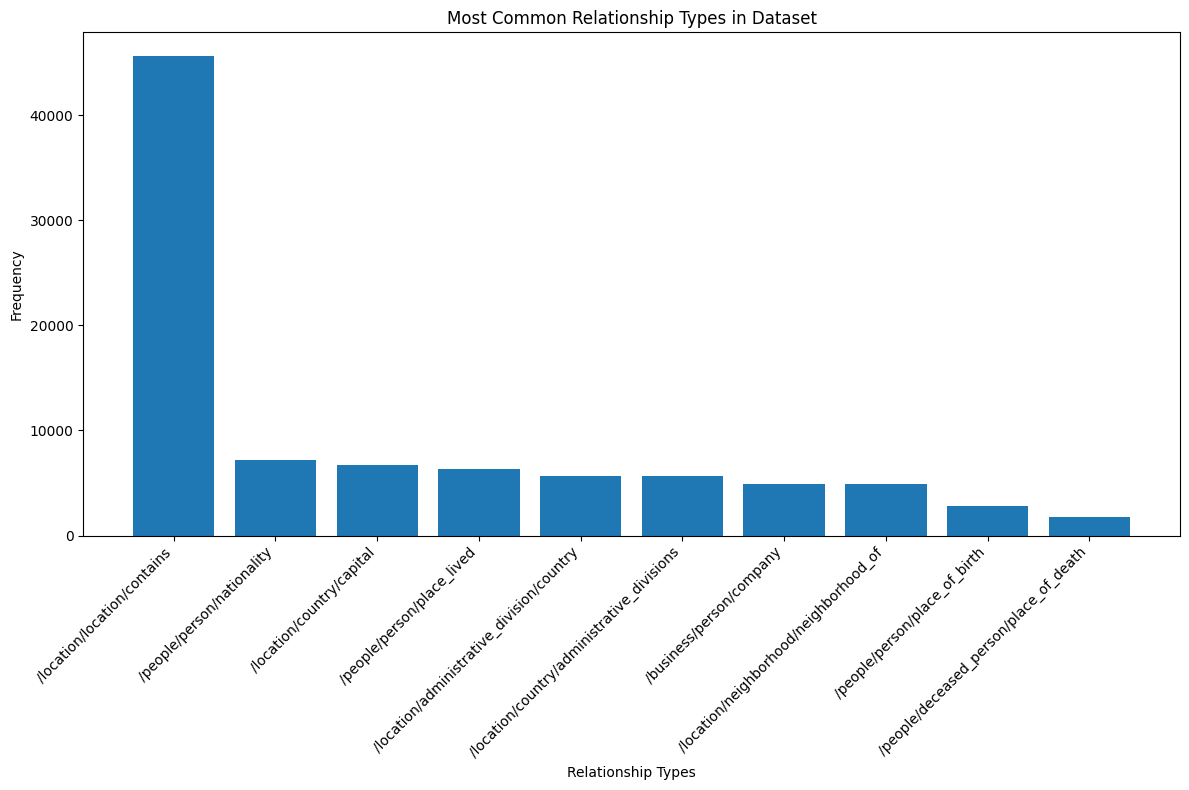


Example Entity Pairs and Their Relationships:
1. Annandale-on-Hudson --/location/location/contains--> Bard College
   Sentence: Massachusetts ASTON MAGNA Great Barrington ; also at Bard College , Annandale-on-Hudson , N.Y. , Jul...

2. North Carolina --/location/location/contains--> Greensboro
   Sentence: North Carolina EASTERN MUSIC FESTIVAL Greensboro , June 25-July 30 ....

3. Debra Hill --/people/person/place_of_birth--> Haddonfield
   Sentence: It will be the final movie credited to Debra Hill , a film producer and native of Haddonfield , who ...

4. Ohio --/location/location/contains--> Columbus
   Sentence: In a 3-0 victory over the Crew on Saturday in Columbus , Ohio , goalkeeper Zach Wells stopped Kyle M...

5. Mexico --/location/location/contains--> Nuevo Laredo
   Sentence: The United States ambassador to Mexico , Tony Garza , said in a statement that he had directed the A...

6. Carlos Ghosn --/business/person/company--> Renault
   Sentence: Under pressure from Mr. Kerkor

In [16]:
# Analyze relationship types and frequencies
def analyze_relationships(data):
    """Analyze the types and frequencies of relationships in the dataset"""
    relationship_counts = {}
    entity_pairs = []
    
    for item in data:
        relation_mentions = item.get('relationMentions', [])
        for rel in relation_mentions:
            rel_type = rel['label']
            entity1 = rel['em1Text']
            entity2 = rel['em2Text']
            
            # Count relationship types
            if rel_type in relationship_counts:
                relationship_counts[rel_type] += 1
            else:
                relationship_counts[rel_type] = 1
            
            # Store entity pairs
            entity_pairs.append({
                'entity1': entity1,
                'entity2': entity2,
                'relationship': rel_type,
                'sentence': item['sentText']
            })
    
    return relationship_counts, entity_pairs

# Analyze relationships
print("Analyzing relationships in the dataset...")
train_rel_counts, train_entity_pairs = analyze_relationships(train_data)

# Display top relationship types
print("\nTop 10 Most Common Relationship Types:")
sorted_relations = sorted(train_rel_counts.items(), key=lambda x: x[1], reverse=True)
for rel_type, count in sorted_relations[:10]:
    print(f"{rel_type}: {count}")

# Create relationship visualization
plt.figure(figsize=(12, 8))
top_relations = dict(sorted_relations[:10])
plt.bar(range(len(top_relations)), list(top_relations.values()))
plt.xlabel('Relationship Types')
plt.ylabel('Frequency')
plt.title('Most Common Relationship Types in Dataset')
plt.xticks(range(len(top_relations)), list(top_relations.keys()), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display some example entity pairs
print("\nExample Entity Pairs and Their Relationships:")
for i, pair in enumerate(train_entity_pairs[:10]):
    print(f"{i+1}. {pair['entity1']} --{pair['relationship']}--> {pair['entity2']}")
    print(f"   Sentence: {pair['sentence'][:100]}...")
    print()

Analyzing relationships in the dataset...

Top 10 Most Common Relationship Types:
/location/location/contains: 45608
/people/person/nationality: 7198
/location/country/capital: 6718
/people/person/place_lived: 6362
/location/administrative_division/country: 5658
/location/country/administrative_divisions: 5658
/business/person/company: 4950
/location/neighborhood/neighborhood_of: 4941
/people/person/place_of_birth: 2813
/people/deceased_person/place_of_death: 1752


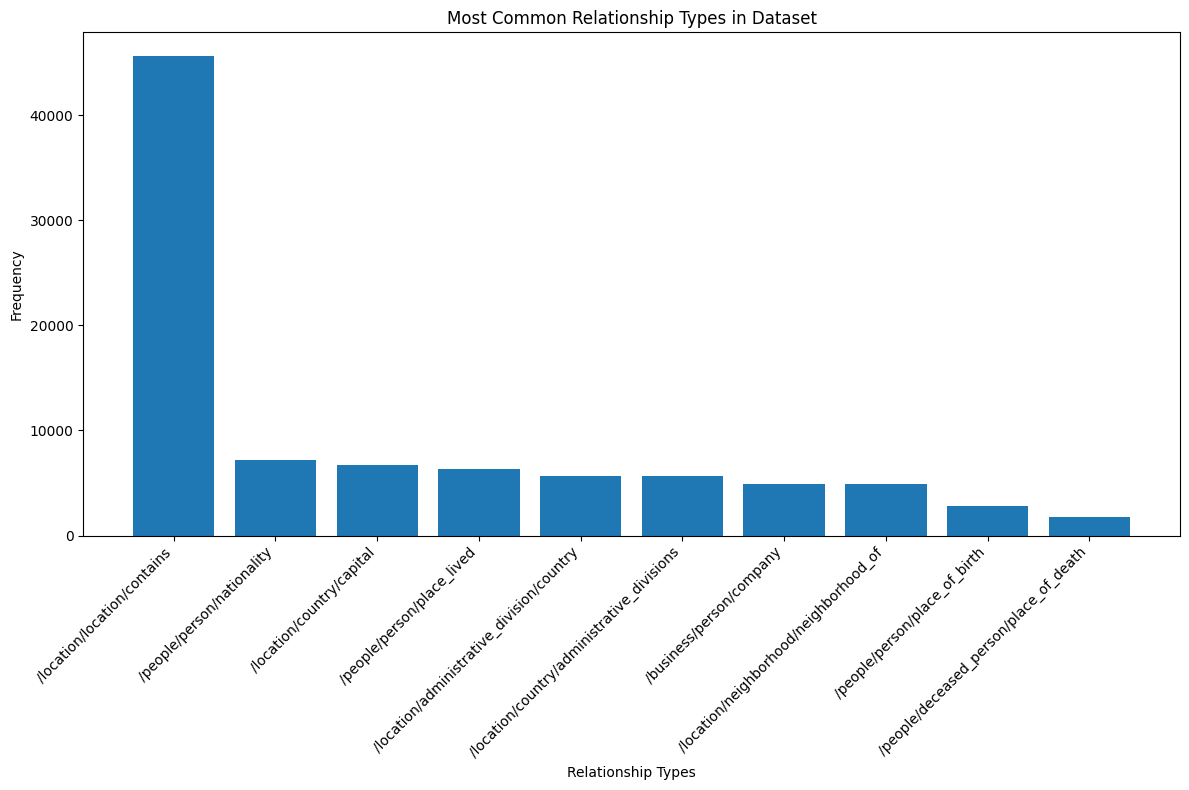


Example Entity Pairs and Their Relationships:
1. Annandale-on-Hudson --/location/location/contains--> Bard College
   Sentence: Massachusetts ASTON MAGNA Great Barrington ; also at Bard College , Annandale-on-Hudson , N.Y. , Jul...

2. North Carolina --/location/location/contains--> Greensboro
   Sentence: North Carolina EASTERN MUSIC FESTIVAL Greensboro , June 25-July 30 ....

3. Debra Hill --/people/person/place_of_birth--> Haddonfield
   Sentence: It will be the final movie credited to Debra Hill , a film producer and native of Haddonfield , who ...

4. Ohio --/location/location/contains--> Columbus
   Sentence: In a 3-0 victory over the Crew on Saturday in Columbus , Ohio , goalkeeper Zach Wells stopped Kyle M...

5. Mexico --/location/location/contains--> Nuevo Laredo
   Sentence: The United States ambassador to Mexico , Tony Garza , said in a statement that he had directed the A...

6. Carlos Ghosn --/business/person/company--> Renault
   Sentence: Under pressure from Mr. Kerkor

In [17]:

# Analyze relationship types and frequencies
def analyze_relationships(data):
    """Analyze the types and frequencies of relationships in the dataset"""
    relationship_counts = {}
    entity_pairs = []
    
    for item in data:
        relation_mentions = item.get('relationMentions', [])
        for rel in relation_mentions:
            rel_type = rel['label']
            entity1 = rel['em1Text']
            entity2 = rel['em2Text']
            
            # Count relationship types
            if rel_type in relationship_counts:
                relationship_counts[rel_type] += 1
            else:
                relationship_counts[rel_type] = 1
            
            # Store entity pairs
            entity_pairs.append({
                'entity1': entity1,
                'entity2': entity2,
                'relationship': rel_type,
                'sentence': item['sentText']
            })
    
    return relationship_counts, entity_pairs

# Analyze relationships
print("Analyzing relationships in the dataset...")
train_rel_counts, train_entity_pairs = analyze_relationships(train_data)

# Display top relationship types
print("\nTop 10 Most Common Relationship Types:")
sorted_relations = sorted(train_rel_counts.items(), key=lambda x: x[1], reverse=True)
for rel_type, count in sorted_relations[:10]:
    print(f"{rel_type}: {count}")

# Create relationship visualization
plt.figure(figsize=(12, 8))
top_relations = dict(sorted_relations[:10])
plt.bar(range(len(top_relations)), list(top_relations.values()))
plt.xlabel('Relationship Types')
plt.ylabel('Frequency')
plt.title('Most Common Relationship Types in Dataset')
plt.xticks(range(len(top_relations)), list(top_relations.keys()), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display some example entity pairs
print("\nExample Entity Pairs and Their Relationships:")
for i, pair in enumerate(train_entity_pairs[:10]):
    print(f"{i+1}. {pair['entity1']} --{pair['relationship']}--> {pair['entity2']}")
    print(f"   Sentence: {pair['sentence'][:100]}...")
    print()

Creating relationship network...

Top 15 Most Connected Entity Pairs:
1. Beijing <-> China (connected 2372 times)
2. Baghdad <-> Iraq (connected 2100 times)
3. Iraq <-> Saddam Hussein (connected 1815 times)
4. China <-> Taiwan (connected 1114 times)
5. Moscow <-> Russia (connected 1080 times)
6. Darfur <-> Sudan (connected 1044 times)
7. France <-> Paris (connected 968 times)
8. Iran <-> Tehran (connected 880 times)
9. Long Island City <-> Queens (connected 758 times)
10. Israel <-> West Bank (connected 753 times)
11. Japan <-> Tokyo (connected 740 times)
12. China <-> Hong Kong (connected 693 times)
13. Manhattan <-> New York (connected 676 times)
14. Damascus <-> Syria (connected 668 times)
15. Brooklyn <-> Fort Greene (connected 630 times)


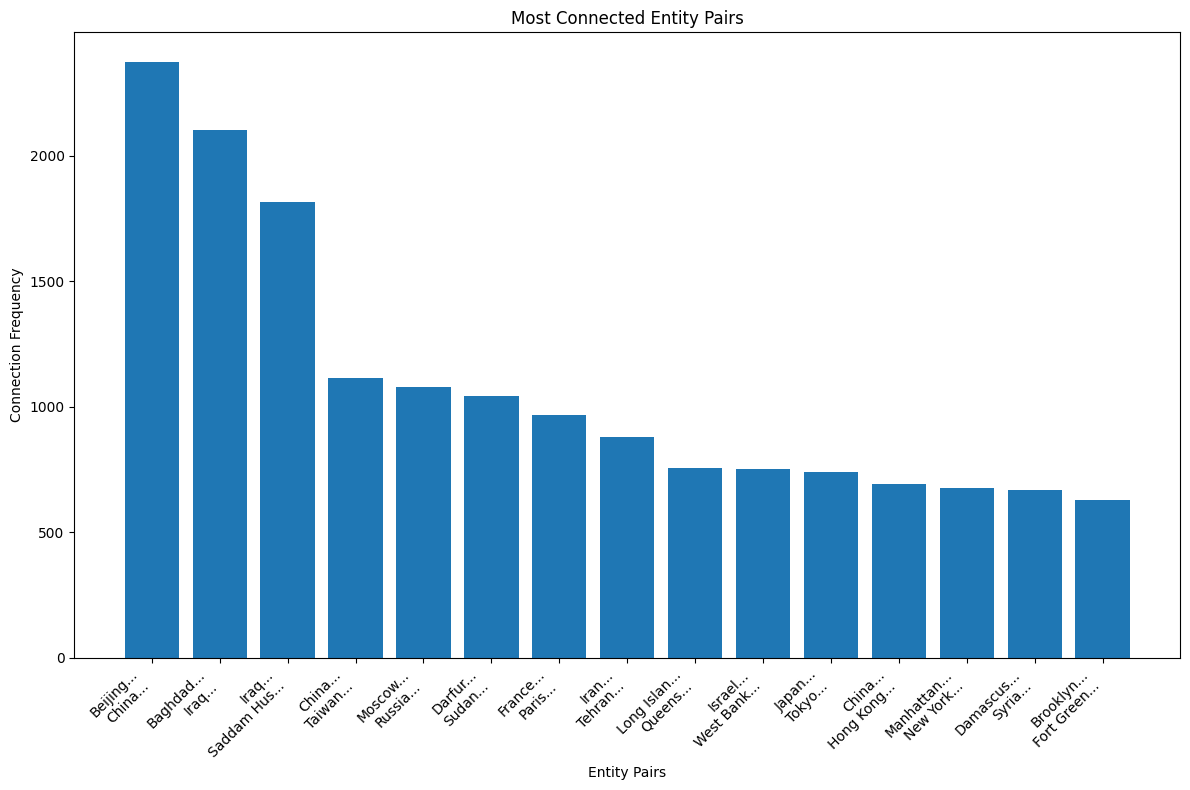

In [18]:
# Create a simple network analysis of relationships
def create_relationship_network(data, top_n=20):
    """Create a network of the most common entity relationships"""
    from collections import defaultdict
    
    # Count entity pair frequencies
    pair_counts = defaultdict(int)
    
    for item in data:
        relation_mentions = item.get('relationMentions', [])
        for rel in relation_mentions:
            entity1 = rel['em1Text']
            entity2 = rel['em2Text']
            pair = tuple(sorted([entity1, entity2]))
            pair_counts[pair] += 1
    
    # Get top pairs
    top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    return top_pairs

# Create relationship network
print("Creating relationship network...")
top_entity_pairs = create_relationship_network(train_data, top_n=15)

# Display the network
print("\nTop 15 Most Connected Entity Pairs:")
for i, (pair, count) in enumerate(top_entity_pairs):
    print(f"{i+1}. {pair[0]} <-> {pair[1]} (connected {count} times)")

# Create a simple network visualization
plt.figure(figsize=(12, 8))
pairs = [pair for pair, count in top_entity_pairs]
counts = [count for pair, count in top_entity_pairs]

plt.bar(range(len(pairs)), counts)
plt.xlabel('Entity Pairs')
plt.ylabel('Connection Frequency')
plt.title('Most Connected Entity Pairs')
plt.xticks(range(len(pairs)), [f"{p[0][:10]}...\n{p[1][:10]}..." for p in pairs], rotation=45, ha='right')
plt.tight_layout()
plt.show()